In [2]:
import pandas as pd
import numpy as np
import multiprocessing
import argparse
from datetime import timedelta
import pyvips
import PIL
import time
import random
import gc
import logging
import os
from pathlib import Path
import sys
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('..')
from src.wsi import slides, filters, tiles, util
from src import dataset

BASE_PATH = Path(os.path.dirname(os.getcwd()))
DATA_PATH = BASE_PATH / 'data' / 'originals'
PROCESSED_DATA = BASE_PATH / 'data' / 'processed'

In [6]:
train = pd.read_csv(BASE_PATH / 'data' / 'testlow.csv')
row = train.iloc[2]
image = pyvips.Image.new_from_file(f'../data/originals/{row["filename"]}', access='sequential')
image.filename, image.width, image.height

('../data/originals/bu5xt1xm.tif', 157949, 72896)

In [7]:
image.get('bands'), image.get('coding'), image.get('format'), image.get('interpretation')

(3, 'none', 'uchar', 'srgb')

In [8]:
image.tiffsave('test.tif', compression="deflate",
                 tile=True, tile_width=256, tile_height=256,
                 pyramid=True)

In [56]:
def rimages(index, train, page):
    filename, res = train.loc[index, ['filename', 'resolution']]
    resizing_factor = res / 0.25
    image = pyvips.Image.new_from_file(f'../data/originals/{filename}', page=page)
    width, height = image.width, image.height
    image = image.affine((resizing_factor, 0, 0, resizing_factor))
    return width, height, image, image.width, image.height

In [4]:
images = pyvips.Image.new_from_file('../data/originals/4s30tyu3.tif', page=5)
images.height, images.width

(12696, 5544)

In [33]:
dftrain = dataset.get_dftrain('../workspace/tiles/data/processed/64/2/')
dftrain[dftrain['n_tiles'] == 2]

training dataset: 310 samples
training dataset: 14631 tiles


,tissue_id,filename,relapse,split,n_tiles,path,tile_id,is_valid
10734,qmsqv731,qmsqv731.tif,0,4,2,../workspace/tiles/data/processed/64/2/qmsqv731_0.jpeg,0,0
10735,qmsqv731,qmsqv731.tif,0,4,2,../workspace/tiles/data/processed/64/2/qmsqv731_1.jpeg,1,0


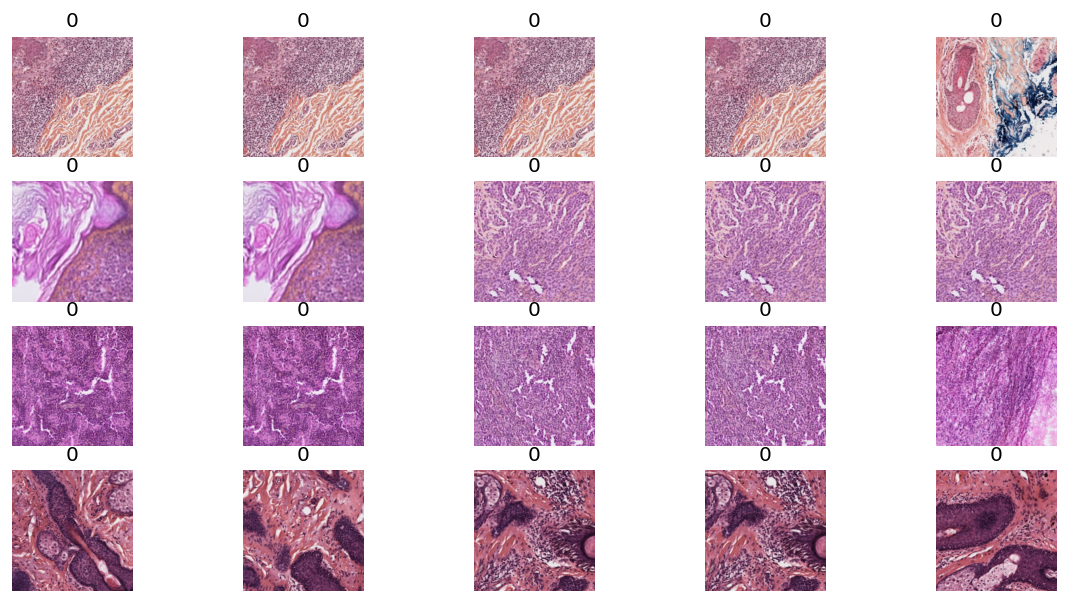

In [38]:
dls = dataset.get_dataloader(dftrain)
dataset.show_tile_batch(dls)